In [1]:
# This code is an extension of the base NN code from 
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html
#
# The changes made here are:
# (1) Add options to use more distribution types - normal, uniform and exponential
# (2) Add different curves to learn and options to increase the learning points
# (3) Code to showcase the Bayesian prior and posterior probabilities and code to graph it
# (4) Modification of the BNN code also to use normal, uniform and exponential distributions 
# (5) Plots of expectation and variance of the predictions
# (6) Plots of the posterior distributions
# (7) Code to demonstrate Chebyshev validation and plot to demonstrate it
# (8) Code to demonstrate Law of Large Numbers and plot to demonstrate it
# (9) Code to demonstrate Central Limit Theorem and plot to demonstrate it

# Posterior samples can be adjusted here
# mcmc = MCMC(nuts_kernel, num_samples=100)
# It takes about 5 minutes to train with 50 samples and 10 minutes to train with 100 samples
# To meaningfully demonstrate CLT, we need 100 samples

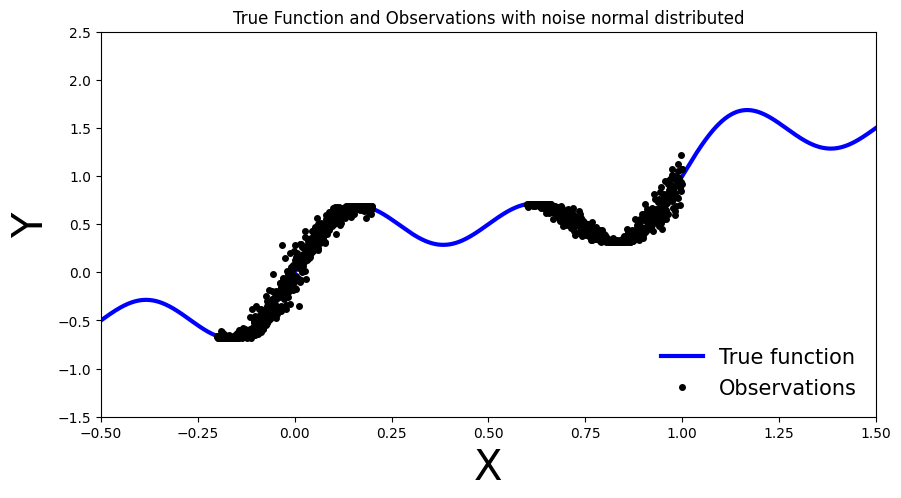

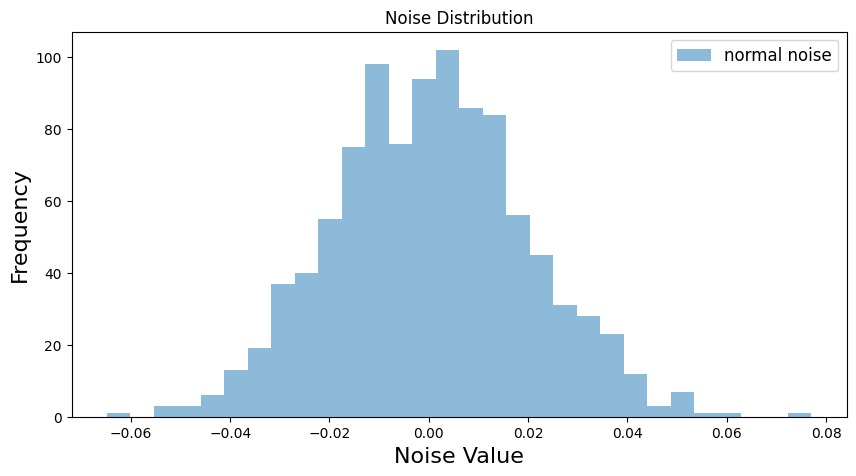

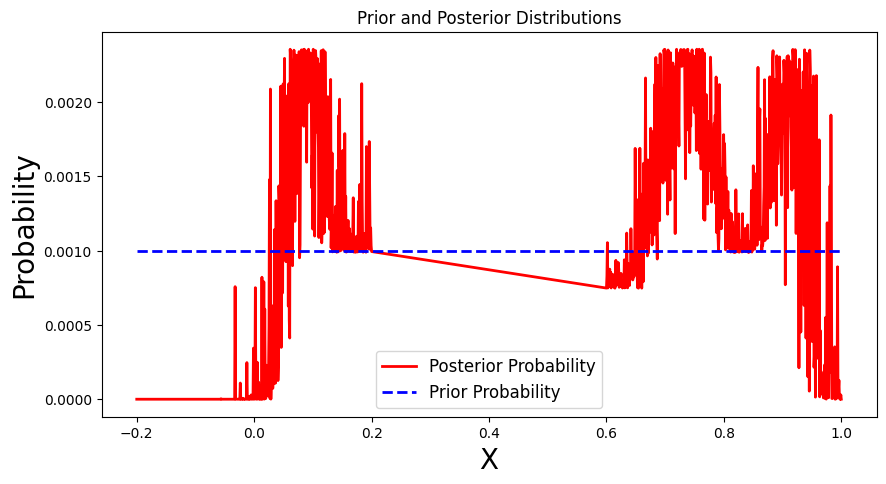

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

variance = 0.02
curve = "choice1" # Option "choice1" and "choice2"
dist_type = "normal" # Options "normal", "uniform" and "exponential"
train_data = "regular" # Options "regular" and "extra"

# generate noise based on variance and probability distribution type
def gen_noise( var, type ):
    # Normal distribution
    if type == "normal":
        noise = var * np.random.randn(x_obs.shape[0])
    elif type == "uniform":
        noise = var * np.random.uniform(low=-1, high=1, size=x_obs.shape[0])
    elif type == "exponential":
        noise = var * np.random.exponential(scale=1.0, size=x_obs.shape[0])
    return noise

def plot_noise( noise ):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(noise, bins=30, alpha=0.5, label=f"{dist_type} noise")
    ax.legend(fontsize=12)
    ax.set_title("Noise Distributions")
    ax.set_xlabel("Noise Value", fontsize=16)
    ax.set_ylabel("Frequency", fontsize=16)
    plt.title("Noise Distribution")
    
def calculate_prior_posterior():
    # Bayes theorem
    # P(Hypothesis|Data) = (P(Data|Hypothesis) * P(Hypothesis)) / P(Data)
    
    # Uniform prior = P(hypothesis)
    prior = []
    n = len(x_obs)
    for _ in x_obs:
        prior.append(1 / n)
    prior = np.array(prior)

    # Gaussian likelihood based on data = (P(Data|Hypothesis)
    likelihood = np.exp(-((y_obs - y_true.mean()) ** 2) / (2 * variance))  
   
    # Calculate posterior - P(Hypothesis|Data)
    posterior = likelihood * prior 
    posterior /= posterior.sum()  # P(Data) - Normalization
    
    return prior, posterior

def plot_prior_posterior(prior, posterior):
    # Plot posterior distribution along with the prior distribution
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x_obs, posterior, 'r-', linewidth=2, label="Posterior Probability")
    ax.plot(x_obs, prior, 'b--', linewidth=2, label="Prior Probability")
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Probability", fontsize=20)
    ax.legend(fontsize=12)
    plt.title("Prior and Posterior Distributions")

# Set random seed for reproducibility
np.random.seed(42)

#create a curve
def get_curve( type, noise, x_obs ):
    if type == "choice1":
        return x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + noise)) + 0.3 * np.sin(4 * np.pi * (x_obs + noise)) + noise
    if type == "choice2":
        return x_obs**2 + 0.5 * np.cos(3 * np.pi * (x_obs + noise)) + 0.2 * np.sin(5 * np.pi * (x_obs + noise)) + noise
    
# Generate data
# These are the true values
x_true = np.linspace(-0.5, 1.5, 1000)
y_true = get_curve (curve, 0, x_true)

# These are the values used to train the network
# For better prediction use below - adds more priors
if train_data == "regular":
    x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
elif train_data == "extra":
    x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500), np.linspace(1.3, 1.4, 50)])

noise = gen_noise( variance, dist_type )
y_obs = get_curve (curve, noise, x_obs)

# Calculating the prior and posterior based on the noise added to the true data
prior, posterior = calculate_prior_posterior()

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)
plt.title(f"True Function and Observations with noise {dist_type} distributed")

# Plot noise distribution
plot_noise(noise)

# Compute prior and posterior using the calculate_prior_posterior function
plot_prior_posterior(prior, posterior)

plt.show()


In [3]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        # This is normal priors
        if dist_type == "normal":
            self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
            self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
            self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
            self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

        elif dist_type == "uniform":
            self.layer1.weight = PyroSample(dist.Uniform(-prior_scale, prior_scale).expand([hid_dim, in_dim]).to_event(2))
            self.layer1.bias = PyroSample(dist.Uniform(-prior_scale, prior_scale).expand([hid_dim]).to_event(1))
            self.layer2.weight = PyroSample(dist.Uniform(-prior_scale, prior_scale).expand([out_dim, hid_dim]).to_event(2))
            self.layer2.bias = PyroSample(dist.Uniform(-prior_scale, prior_scale).expand([out_dim]).to_event(1))
        elif dist_type == "exponential":
            self.layer1.weight = PyroSample(dist.Exponential(rate=1.0).expand([hid_dim, in_dim]).to_event(2))
            self.layer1.bias = PyroSample(dist.Exponential(rate=1.0).expand([hid_dim]).to_event(1))
            self.layer2.weight = PyroSample(dist.Exponential(rate=1.0).expand([out_dim, hid_dim]).to_event(2))
            self.layer2.bias = PyroSample(dist.Exponential(rate=1.0).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()

        if dist_type == "normal":
            sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise
            # Sampling model
            with pyro.plate("data", x.shape[0]):
                obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        elif dist_type == "uniform":
            sigma = pyro.sample("sigma", dist.Uniform(.1, 2.0))  # Infer the response noise
            # Sampling model
            with pyro.plate("data", x.shape[0]):
                obs = pyro.sample("obs", dist.Uniform(mu - sigma, mu + sigma), obs=y)
        elif dist_type == "exponential":
            epsilon = 1e-6  # Small value to ensure positivity
            mu = torch.abs(mu) + epsilon  # Ensure mu is positive
            with pyro.plate("data", x.shape[0]):
                obs = pyro.sample("obs", dist.Exponential(rate=1/mu), obs=y)

            #sigma = pyro.sample("sigma", dist.Exponential(rate=1.0))  # Prior for scale parameter
            #with pyro.plate("data", x.shape[0]):
             #   obs = pyro.sample("obs", dist.Exponential(rate=1/sigma), obs=y)

        return mu


/Users/anil/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
# This number can be varied
mcmc = MCMC(nuts_kernel, num_samples=100)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

# Run MCMC
mcmc.run(x_train, y_train)

Sample: 100%|██████████████████████████████████████████| 200/200 [01:47,  1.86it/s, step size=3.92e-04, acc. prob=0.976]                                                                               


In [5]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = predictive(x_test)



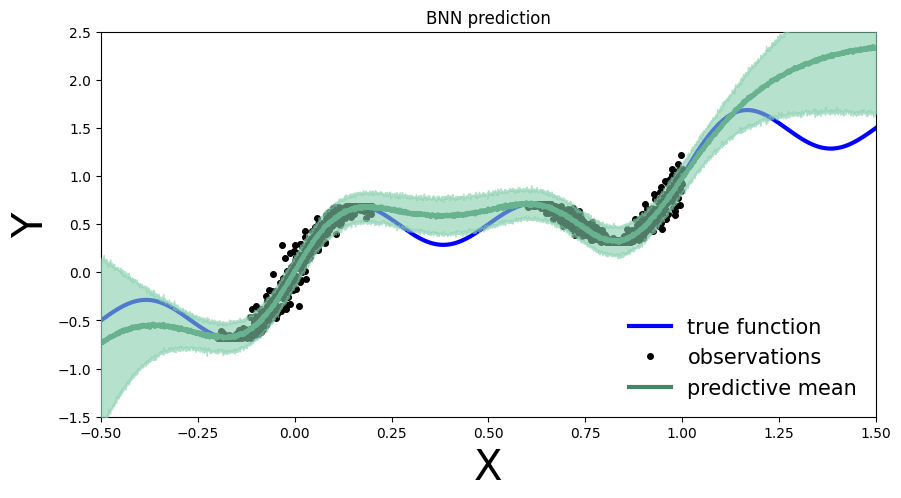

In [6]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)
    plt.title(f"BNN prediction")

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)
plot_predictions(preds)

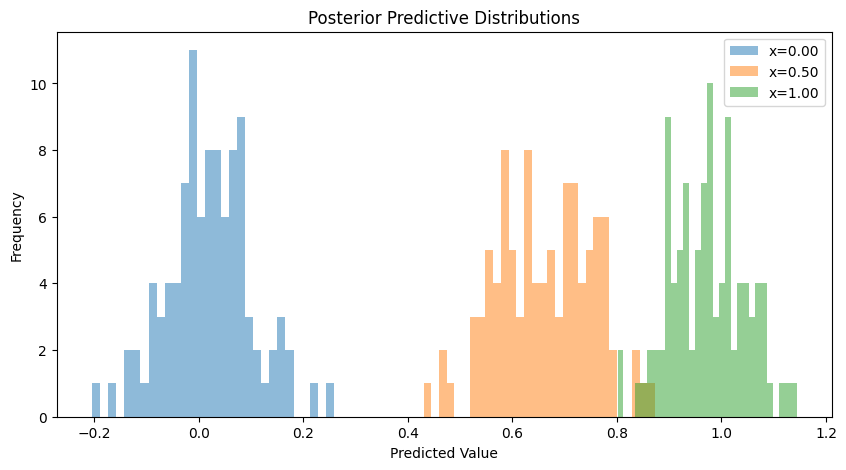

In [7]:
# Conditional distributions
# The Bayesian model predicts a distribution of possible y-values 
# (posterior predictive distribution) for each input 
# rather than a single deterministic output.
# Choose specific inputs to demonstrate conditional distributions

y_pred = preds['obs'].detach().numpy()  # Extract posterior predictions

# Define specific input values of interest where we want to observe conditional distributions
x_specific = [0.0, 0.5, 1.0]

# Find the indices in the test data `x_test` that are closest to the specified inputs `x_specific`
indices = []  # Initialize an empty list to store indices
for x in x_specific:  # Loop through each value in x_specific
    diff = torch.abs(x_test - torch.tensor(x))  # Compute absolute differences
    idx = torch.argmin(diff).item()  # Find the index of the minimum difference
    indices.append(idx)  # Append the index to the list

# Plot posterior predictive distributions for these inputs
plt.figure(figsize=(10, 5)) 
for i, idx in enumerate(indices): 
    plt.hist(y_pred[:, idx], bins=30, alpha=0.5, label=f"x={x_specific[i]:.2f}")

plt.title("Posterior Predictive Distributions")  
plt.xlabel("Predicted Value") 
plt.ylabel("Frequency") 
plt.legend() 
plt.show() 


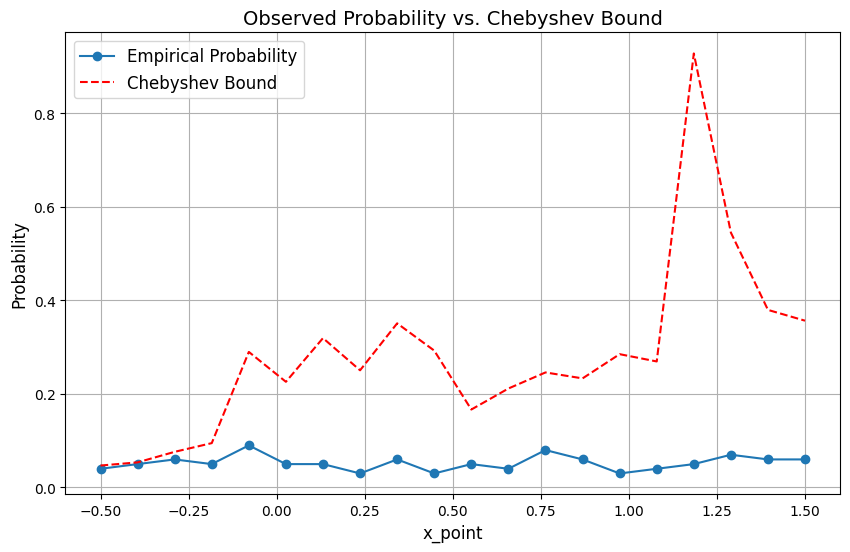

In [8]:
# Chebyshev Validation
y_pred = preds['obs'].detach().numpy()  # Extract posterior predictions
predictive_mean = y_pred.mean(axis=0)   # Mean across posterior samples
predictive_variance = y_pred.var(axis=0)  # Variance across posterior samples

def validate_chebyshev_demo(x_test, predictive_mean, predictive_variance, y_pred, 
                       c=1):
    empirical_probs = []
    chebyshev_bounds = []
    x_points = torch.linspace(xlims[0], xlims[1], 20).numpy()  # 20 equally spaced points

    for x_point in x_points:
        idx = torch.argmin(torch.abs(x_test - torch.tensor(x_point))).item()

        # Extract mean and variance for the chosen input
        mean = predictive_mean[idx]
        variance = predictive_variance[idx]
        std_dev = np.sqrt(variance)

        # Chebyshev's bound for |X - mean| >= c
        chebyshev_bound = variance / (c**2)
        chebyshev_bounds.append(chebyshev_bound)

        c = 2 * std_dev

        # Observed probability
        count = 0  # Initialize a counter for samples satisfying the condition
        total_samples = len(y_pred[:, idx])  # Total number of posterior samples

        for y in y_pred[:, idx]:  # Loop through each posterior sample
            if abs(y - mean) >= c:  # Check if the condition is met
                count += 1  # Increment the counter

        empirical_prob = count / total_samples  # Calculate the proportion
        empirical_probs.append(empirical_prob)
        
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(x_points, empirical_probs, label="Empirical Probability", marker='o')
    plt.plot(x_points, chebyshev_bounds, label="Chebyshev Bound", linestyle='--', color='red')
    plt.title("Observed Probability vs. Chebyshev Bound", fontsize=14)
    plt.xlabel("x_point", fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

    #return x_points, empirical_probs, chebyshev_bounds

# Validate Chebyshev's inequality for a range of x_point values
validate_chebyshev_demo(x_test, predictive_mean, predictive_variance, y_pred, c=2)


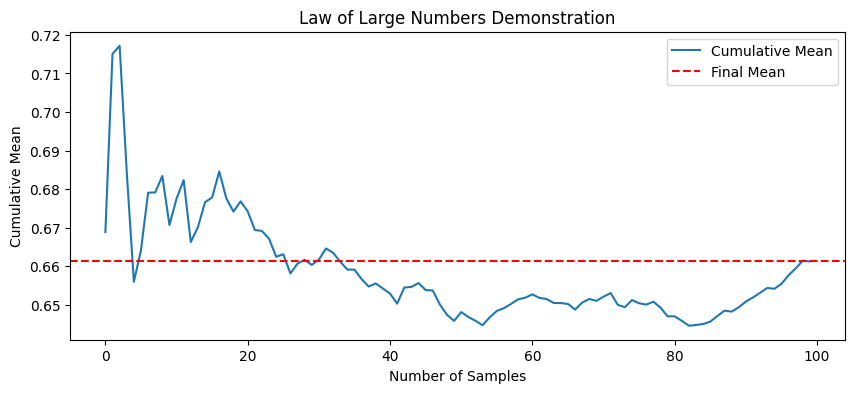

In [9]:
#LLN Demonstration
#As the size of a sample increases, the sample mean will converge to the 
#expected value (mean) of the underlying data

def lln_demo():
    # Choose specific input to isolate the behavior of the model's predictions
    x_point = 0.5

    # Find the index closest to this point
    idx = torch.argmin(torch.abs(x_test - torch.tensor(x_point))).item()

    # Extract posterior predictions
    y_pred = preds['obs'].detach().numpy() 

    # Compute cumulative means for increasing numbers of samples
    # Initialize an empty list to store cumulative means
    cumulative_means = []

    # Get posterior samples for the specific x_point
    samples = y_pred[:, idx]

    # Loop over the number of samples
    cumulative_sum = 0  # Running total of the sum
    for i in range(len(samples)):
        cumulative_sum += samples[i]  # Add the current sample to the cumulative sum
        cumulative_mean = cumulative_sum / (i + 1)  # Compute the mean up to the current sample
        cumulative_means.append(cumulative_mean)  # Store the mean in the list

    # Convert the list to a NumPy array (optional, for consistency)
    cumulative_means = np.array(cumulative_means)

    # Plot cumulative means
    plt.figure(figsize=(10, 4))
    plt.plot(cumulative_means, label="Cumulative Mean")
    plt.axhline(y=cumulative_means[-1], color='r', linestyle='--', label="Final Mean")
    plt.title("Law of Large Numbers Demonstration")
    plt.xlabel("Number of Samples")
    plt.ylabel("Cumulative Mean")
    plt.legend()
    plt.show()

# Run LLN demonstration
lln_demo()

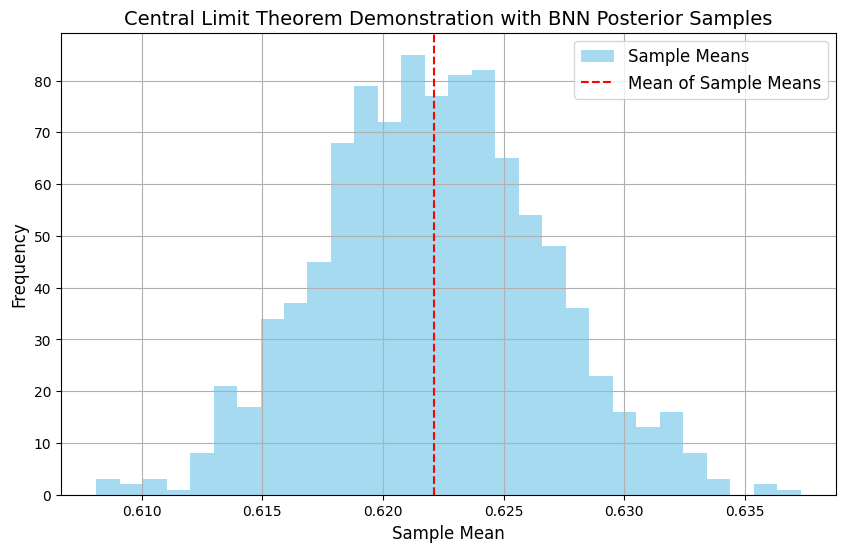

In [10]:
# CLT Demonstration
# The sampling distribution of the mean of a large number of independent, identically distributed random 
# variables approaches a normal
def clt_demo():
    # Extract posterior predictions
    y_pred = preds['obs'].detach().numpy()
    
    # Define the number of resamples and the sample size
    resample_count = 1000
    sample_size = 50  # Increase this to demonstrate better Gaussian convergence
    
    # Storage for sample means
    sample_means = []

    # Randomly sample from the posterior predictions
    for _ in range(resample_count):
        # Randomly choose `sample_size` indices from posterior samples
        sample_indices = np.random.choice(y_pred.shape[0], size=sample_size, replace=False)
        # Compute the mean of the chosen samples for one x_point
        sample_means.append(y_pred[sample_indices].mean())

    # Plot histogram of sample means to demonstrate Gaussian convergence
    plt.figure(figsize=(10, 6))
    plt.hist(sample_means, bins=30, alpha=0.75, color='skyblue', label="Sample Means")
    plt.title("Central Limit Theorem Demonstration with BNN Posterior Samples", fontsize=14)
    plt.xlabel("Sample Mean", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.axvline(np.mean(sample_means), color='red', linestyle='--', label="Mean of Sample Means")
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

# Run CLT Demonstration
clt_demo()
